In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"praneethratna","key":"4997eb4fb4e67eb4ec38a0e771ad035f"}'}

In [3]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

  0% 0.00/3.30M [00:00<?, ?B/s]
100% 3.30M/3.30M [00:00<00:00, 110MB/s]


In [4]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2021-07-08 08:34:45--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-08 08:34:45--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.15MB/s    in 2m 40s  

2021-07-08 08:37:25 (5.15 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [6]:
!unzip news-headlines-dataset-for-sarcasm-detection.zip
!unzip glove.6B.zip

Archive:  news-headlines-dataset-for-sarcasm-detection.zip
replace Sarcasm_Headlines_Dataset.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Sarcasm_Headlines_Dataset.json  
replace Sarcasm_Headlines_Dataset_v2.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Sarcasm_Headlines_Dataset_v2.json  
Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [195]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense , Embedding , LSTM , Dropout , Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras.models import load_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
import json
raw_data = list()
with open('Sarcasm_Headlines_Dataset.json','r') as f:
  for line in f:
    raw_data.append(json.loads(line))

In [21]:
headlines = list()
is_sarcastic = list()
for data in raw_data:
  headlines.append(data['headline'])
  is_sarcastic.append(data['is_sarcastic'])

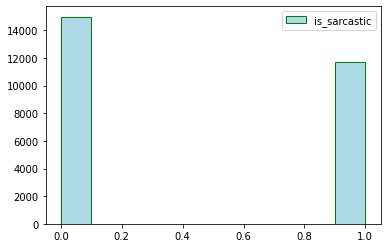

In [37]:
plt.hist(is_sarcastic,color = 'lightblue',label='is_sarcastic',edgecolor = 'green')
plt.legend()
plt.show()

In [274]:
cachedstopwords = set(stopwords.words('english'))
def headlines_preprocessing(headlines,tokenizer):
  temp = list()
  for headline in headlines:
    words = headline.split()
    words = [word for word in words if word not in cachedstopwords]
    words = [word.lower() for word in words]
    words = [word for word in words if (len(word) > 1)]
    words = [word for word in words if not word.isdigit()]
    updated = ' '.join(words)
    updated = re.sub(r'[0-9]','',updated)
    temp.append(updated)
  return temp

In [275]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(input_headlines)
word_index = tokenizer.word_index
vocab_size = len(word_index)
input_headlines = headlines_preprocessing(headlines,tokenizer)
sequences = tokenizer.texts_to_sequences(input_headlines)
maxlen = max([len(sequence) for sequence in sequences])
input_padded = pad_sequences(sequences,maxlen=maxlen,padding='pre')
xtrain,xtest,ytrain,ytest = train_test_split(input_padded,is_sarcastic,test_size = 0.2,random_state  =10)

In [276]:
glove_path = '/content/glove.6B.300d.txt'
glove_vectors = dict()
embedding_dim = 300
with open(glove_path,'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],dtype=np.float32)
    glove_vectors[word] = vector

embeddings_matrix = np.zeros((vocab_size+1,embedding_dim))
for word , i in word_index.items():
  vector = glove_vectors.get(word)
  if vector is not None:
    embeddings_matrix[i] = vector

In [146]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 34, 100)           2912500   
_________________________________________________________________
lstm_29 (LSTM)               (None, 34, 64)            42240     
_________________________________________________________________
dropout_23 (Dropout)         (None, 34, 64)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 128)             

In [296]:
model = Sequential()
model.add(Embedding(vocab_size+1,embedding_dim,weights = [embeddings_matrix],trainable = False,input_length=maxlen,mask_zero=True))
model.add(LSTM(32,return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.4))
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation = 'sigmoid'))

In [297]:
checkpoint_path = 'model.save'
cp_callback = ModelCheckpoint(checkpoint_path,monitor = 'val_loss',mode = 'min',save_freq='epoch')
model.compile(optimizer = Adam(lr = 0.001),loss = 'binary_crossentropy',metrics = ['acc'])
history = model.fit(xtrain,np.array(ytrain),batch_size = 256,epochs = 10,verbose = 1,callbacks = [cp_callback],validation_split = 0.2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
67/67 [==============================] - 21s 169ms/step - loss: 0.6579 - acc: 0.6064 - val_loss: 0.5114 - val_acc: 0.7527


INFO:tensorflow:Assets written to: model.save/assets


INFO:tensorflow:Assets written to: model.save/assets


Epoch 2/10
67/67 [==============================] - 9s 131ms/step - loss: 0.5126 - acc: 0.7581 - val_loss: 0.4864 - val_acc: 0.7677


INFO:tensorflow:Assets written to: model.save/assets


INFO:tensorflow:Assets written to: model.save/assets


Epoch 3/10
67/67 [==============================] - 9s 132ms/step - loss: 0.4702 - acc: 0.7729 - val_loss: 0.4554 - val_acc: 0.7892


INFO:tensorflow:Assets written to: model.save/assets


INFO:tensorflow:Assets written to: model.save/assets


Epoch 4/10
67/67 [==============================] - 9s 136ms/step - loss: 0.4252 - acc: 0.8068 - val_loss: 0.4442 - val_acc: 0.7969


INFO:tensorflow:Assets written to: model.save/assets


INFO:tensorflow:Assets written to: model.save/assets


Epoch 5/10
67/67 [==============================] - 9s 136ms/step - loss: 0.4002 - acc: 0.8172 - val_loss: 0.4516 - val_acc: 0.7955


INFO:tensorflow:Assets written to: model.save/assets


INFO:tensorflow:Assets written to: model.save/assets


Epoch 6/10
67/67 [==============================] - 9s 133ms/step - loss: 0.3632 - acc: 0.8389 - val_loss: 0.4297 - val_acc: 0.8070


INFO:tensorflow:Assets written to: model.save/assets


INFO:tensorflow:Assets written to: model.save/assets


Epoch 7/10
67/67 [==============================] - 9s 132ms/step - loss: 0.3417 - acc: 0.8510 - val_loss: 0.4501 - val_acc: 0.8037


INFO:tensorflow:Assets written to: model.save/assets


INFO:tensorflow:Assets written to: model.save/assets


Epoch 8/10
67/67 [==============================] - 8s 126ms/step - loss: 0.3125 - acc: 0.8656 - val_loss: 0.4494 - val_acc: 0.8039


INFO:tensorflow:Assets written to: model.save/assets


INFO:tensorflow:Assets written to: model.save/assets


Epoch 9/10
67/67 [==============================] - 8s 126ms/step - loss: 0.2959 - acc: 0.8728 - val_loss: 0.4650 - val_acc: 0.8077


INFO:tensorflow:Assets written to: model.save/assets


INFO:tensorflow:Assets written to: model.save/assets


Epoch 10/10
67/67 [==============================] - 9s 128ms/step - loss: 0.2669 - acc: 0.8905 - val_loss: 0.4734 - val_acc: 0.8074


INFO:tensorflow:Assets written to: model.save/assets


INFO:tensorflow:Assets written to: model.save/assets


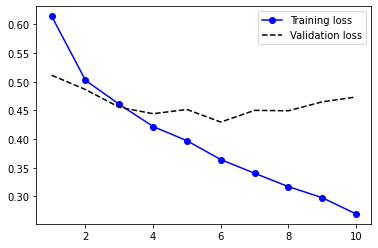

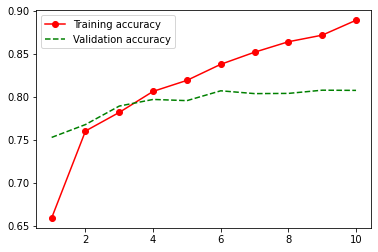

In [309]:
epochs = range(1,11)
acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

plt.plot(epochs,loss,'bo-',label = 'Training loss')
plt.plot(epochs,val_loss,'k--',label = 'Validation loss')
plt.legend()
plt.show()

plt.plot(epochs,acc,'ro-',label = 'Training accuracy')
plt.plot(epochs,val_acc,'g--',label = 'Validation accuracy')
plt.legend()
plt.show()

In [299]:
model.evaluate(xtest,np.array(ytest))

167/167 [==============================] - 2s 11ms/step - loss: 0.4679 - acc: 0.8143


[0.4679441452026367, 0.8143017888069153]

In [ ]:
import shutil
shutil.make_archive('model','zip','/content/model.save')
from google.colab import files
files.download('model.zip')

In [303]:
h = load_model('model.save')
def predict_is_sarcastic(new_headlines,tokenizer):
  preprocessed = headlines_preprocessing(new_headlines,tokenizer)
  sequences = tokenizer.texts_to_sequences(preprocessed)
  input_padded = pad_sequences(sequences,maxlen=maxlen,padding='pre')
  predictions = h.predict(input_padded)
  return predictions      

In [305]:
#Unpredicted samples taken from bestofonline.com
unpredicted = ["Miracle cure kills fifth patient","Cows lose their jobs as milk prices drop", "Amphibious pitcher makes debut",
            "State population to double by 2040, babies to blame","Most Earthquake Damage is Caused by Shaking","Murderer says detective ruined his reputation",
            "Utah Poison Control Center reminds everyone not to take poison","Farmer using cannon to protect watermelons","Goat accused of robbery",
            "Over 157 million individuals fully vaccinated against Covid, says CDC","Most Earthquake damage is caused by shaking"]
predictions = predict_is_sarcastic(unpredicted,tokenizer)
count = 0
for prediction in predictions:
  if prediction > 0.5:
    print("The news headline is sarcastic")
  else:
    print("The news headline is not sarcastic")   

The news headline is sarcastic
The news headline is not sarcastic
The news headline is sarcastic
The news headline is sarcastic
The news headline is sarcastic
The news headline is sarcastic
The news headline is not sarcastic
The news headline is sarcastic
The news headline is sarcastic
The news headline is not sarcastic
The news headline is sarcastic
